#### Import packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
pd.set_option('display.max_columns', 999)
import matplotlib.pylab as plt
import math
import collections
from matplotlib.pyplot import figure

import community
import networkx as nx
from igraph import *

from sklearn.cluster import DBSCAN

from sklearn.neighbors import kneighbors_graph

from sklearn.preprocessing import StandardScaler

from os import listdir
from os.path import isfile, join

#### Read data

In [2]:
data = pd.read_csv('google_prooptima/dt.csv',index_col=0)
data.head(2)
date = 'date'

#### Selection
- Focus on 1 'KPI' 
    - 'Cellular sector ID', date, 'Location (lng)', 'Location (lat)'

In [3]:
KPI = '4G_ERI_User_Throughput_DL_kbps'
dropped = data[['Cellular sector ID', KPI, date ,'Location (lng)', 'Location (lat)']]

- Reshape and remove sectors with missing values for more than x samples

In [4]:
rv = 21# Threshold for removing lines with NaN values
reshaped = dropped.pivot(index='Cellular sector ID', columns=date, values=KPI)
print('Length of', KPI, 'is', len(reshaped))
reshaped = reshaped.dropna(thresh = rv) # Remove lines with NaN values
print('Length of', KPI, 'after removing NaN values is', len(reshaped))
reshaped.head(2)

Length of 4G_ERI_User_Throughput_DL_kbps is 30844
Length of 4G_ERI_User_Throughput_DL_kbps after removing NaN values is 8424


date                         2018-09-03    2018-09-04   2018-09-05  \
Cellular sector ID                                                   
lte:234:10:32768:128001902          NaN           NaN          NaN   
lte:234:10:32768:128001912  9912.308891  10848.471781  9930.231213   

date                          2018-09-06    2018-09-07    2018-09-08  \
Cellular sector ID                                                     
lte:234:10:32768:128001902  11245.891057  10477.790362           NaN   
lte:234:10:32768:128001912  10093.671602  10057.348621  10694.174683   

date                          2018-09-09    2018-09-10    2018-09-11  \
Cellular sector ID                                                     
lte:234:10:32768:128001902  11571.409736  11555.583602  12407.102079   
lte:234:10:32768:128001912   9576.867980   9293.541291  10584.375651   

date                          2018-09-12    2018-09-13    2018-09-14  \
Cellular sector ID                                                     
lte:234:10:32768:128001902  12565.348850  11351.098072  12764.928212   
lte:234:10:32768:128001912   9996.853852   9964.047546   9757.003720   

date                          2018-09-15    2018-09-16    2018-09-17  \
Cellular sector ID                                                     
lte:234:10:32768:128001902  11932.956037  10021.006639  13769.092503   
lte:234:10:32768:128001912  10229.727774   9213.066422  10746.037673   

date                          2018-09-18    2018-09-19    2018-09-20  \
Cellular sector ID                                                     
lte:234:10:32768:128001902  13416.208978  12224.681674  11348.260503   
lte:234:10:32768:128001912   9809.916654  10984.282676  10189.329357   

date                          2018-09-21    2018-09-22    2018-09-23  \
Cellular sector ID                                                     
lte:234:10:32768:128001902  10952.191938  12039.664788  12091.150465   
lte:234:10:32768:128001912   9795.453470  10368.402815  10688.163214   

date                          2018-09-24    2018-09-25    2018-09-26  \
Cellular sector ID                                                     
lte:234:10:32768:128001902  12008.925176  17336.536634  11746.600759   
lte:234:10:32768:128001912  10033.158879  10343.082974   9502.047061   

date                         2018-09-27    2018-09-28    2018-09-29  \
Cellular sector ID                                                    
lte:234:10:32768:128001902  9708.899315  10007.343506  11956.883690   
lte:234:10:32768:128001912  9768.529956   8838.323233  10169.829496   

date                          2018-09-30  
Cellular sector ID                        
lte:234:10:32768:128001902  13477.007257  
lte:234:10:32768:128001912   9705.129548

### A simple example 
- Plot 2 sectors
- Compute the distance

2439.3517751210916

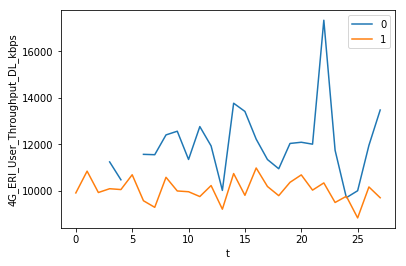

In [5]:
rd1 = reshaped.iloc[0,:].values
rd2 = reshaped.iloc[1,:].values

plt.plot(rd1, label = '0')
plt.plot(rd2, label = '1')

plt.xlabel('t')
plt.ylabel(KPI)
plt.legend()

is_squared = 1
distances = np.zeros(len(rd1))
if (is_squared==0): 
    distances = abs(rd1-rd2)
else:
    distances = abs(rd1-rd2)**2
        
dis =  np.sqrt(np.nanmean(distances))
dis

#### This function:
- Takes as input the reshaped dataframe
- Outputs 'dist', 'max', 'min' and 'std'
- It must be used only for univariate scenarios

In [19]:
def distance_oneKPI(x):
    
    resv = x.values
    
    diff = resv[:, :, None] - resv[:, :, None].T # Broadcast
    # print(diff.shape)
    
    sq = diff*diff # Square 
    
    dist = np.sqrt(np.nanmean(sq,axis=1))
    
    mx = np.nanmax(sq,axis=1) # max
    mn = np.nanmin(sq,axis=1) # min
    sd = np.nanstd(sq,axis=1) # std
    
    return dist, mx, mn, sd

###### Note
- How to average only if k or less NaN values are present??
- Should we imputate??
- Should we apply standardization to capture same trends?? Yes we need that.

In [20]:
std = 1

if std==0:
    dist, mx, mn, sd = distance_oneKPI(reshaped)
else:
    reshaped_std = pd.DataFrame(StandardScaler().fit_transform(X=reshaped.T).T, index = reshaped.index, columns = reshaped.columns)
    dist, mx, mn, sd = distance_oneKPI(reshaped_std) 

#### This function:
- Takes as input the reshaped dataframe
- Outputs 'dist'
- It must be used only for multivariate scenarios

In [6]:
def distance_multipleKPIs(x):
    
    resv = x.values
    
    diff = resv[:, None] - resv[:, None].T # Broadcast
    # diff = np.subtract(resv[:, :, None], resv[:, :, None].T)
    # print(diff.shape)
    
    sq = diff*diff # Square 
    
    return sq

- Find intersected nodes

In [7]:
KPIS = ['4G_ERI_User_Throughput_DL_kbps', '4G_ERI_Cell Throughput_UL_kbps']

path='prooptima'
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

date = 'period'
rv = 16
com = []
for days in range(len(onlyfiles)):
    data = pd.read_csv(''.join([path,'/',onlyfiles[days]]))
        
    iidd = []
    for i in range(len(KPIS)):
        dropped = data[['Cellular sector ID', KPIS[i], date, 'Location (lng)', 'Location (lat)']]
        reshaped = dropped.pivot(index='Cellular sector ID', columns= date, values=KPIS[i])
        del dropped
        #print('Length of', KPIS[i], 'is', len(reshaped))
        reshaped = reshaped.dropna(thresh = rv) # Remove lines with NAs
        #print('Length of', KPIS[i], 'after removing NaN values is', len(reshaped))
        iidd.append(reshaped.index.values)

    common_sectors = set(iidd[0]).intersection(*iidd)   # Find intersection of sectors
    print('The number of intersected sectors in day',days, 'is:', len(common_sectors))
    com.append(common_sectors)
common = set(com[0]).intersection(*com)   # Find intersection of sectors
print('Total number of intersected sectors is', len(common))

The number of intersected sectors in day 0 is: 9642
The number of intersected sectors in day 1 is: 9570
The number of intersected sectors in day 2 is: 9545
The number of intersected sectors in day 3 is: 9741
The number of intersected sectors in day 4 is: 7450
The number of intersected sectors in day 5 is: 8629
The number of intersected sectors in day 6 is: 8539
The number of intersected sectors in day 7 is: 9552
The number of intersected sectors in day 8 is: 9605
The number of intersected sectors in day 9 is: 10136
The number of intersected sectors in day 10 is: 9084
The number of intersected sectors in day 11 is: 9480
The number of intersected sectors in day 12 is: 8841
The number of intersected sectors in day 13 is: 7636
The number of intersected sectors in day 14 is: 9634
The number of intersected sectors in day 15 is: 9590
The number of intersected sectors in day 16 is: 9696
The number of intersected sectors in day 17 is: 8656
The number of intersected sectors in day 18 is: 9428
Th

In [ ]:
std = 1

path='prooptima'
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

for days in range(len(onlyfiles)):
    data = pd.read_csv(''.join([path,'/',onlyfiles[days]]))
    number_of_hours = len(data.hour.unique())
    # number_of_hours = 5 # Set the number of hours manually
    
    # for i in range(len(KPIS)):
    #     print ('Iteration for KPI '+str(i))
    #     dropped = data[['Cellular sector ID', KPIS[i], date,'Location (lng)', 'Location (lat)']]
    #     reshaped = dropped.pivot(index='Cellular sector ID', columns = date, values=KPIS[i])
    #     del dropped
    #     reshaped = reshaped.dropna(thresh = rv) # Remove lines with NAs
    #     reshaped = reshaped.loc[reshaped.index.isin(common_sectors)] 

    #     if std==0:
    #         dist, mx, mn, sd = distance_multipleKPIs(reshaped)
    #     else:
    #         reshaped_std = pd.DataFrame(StandardScaler().fit_transform(X=reshaped.T).T, index = reshaped.index, columns = reshaped.columns)
    #         for w in range(5):
    #             if w==0:
    #                 sq = distance_multipleKPIs(reshaped_std.iloc[:,w]) 
    #             else:
    #                 sq = np.nansum(np.dstack((sq,distance_multipleKPIs(reshaped_std.iloc[:,w]))),2)
    #             if i==0:
    #                 sq_m = sq
    #             else:
    #                 sq_m = np.add(sq_m,sq)
    #             del sq
    # dist = np.sqrt(sq_m)        

    for w in range(number_of_hours):
        for i in range(len(KPIS)):
            # print ('Day: ', days, ' Hour: ', w, ' KPI: ', i)
            # dropped = data[['Cellular sector ID', KPIS[i], date,'Location (lng)', 'Location (lat)']]
            reshaped = data.pivot(index='Cellular sector ID', columns = date, values=KPIS[i])
            # del dropped
            # reshaped = reshaped.dropna(thresh = rv) # Remove lines with NAs
            reshaped = reshaped.loc[reshaped.index.isin(common)] 
            if std==0:
                sq = distance_multipleKPIs(reshaped.iloc[:,w])
            else:
                reshaped_std = pd.DataFrame(StandardScaler().fit_transform(X=reshaped.T).T, index = reshaped.index, columns = reshaped.columns)
                sq = distance_multipleKPIs(reshaped_std.iloc[:,w]) 
            if i==0:
                sq_kpis = sq
            else:
                sq_kpis = np.nansum(np.dstack((sq_kpis,sq)),2)
            del sq
        if w==0:
            sq_hours = sq_kpis
        else:
            sq_hours = np.nansum(np.dstack((sq_hours,sq_kpis)),2)
        del sq_kpis  
    if days==0:
        sq_days = sq_hours
    else:
        sq_days = np.nansum(np.dstack((sq_days,sq_hours)),2)
    del sq_hours
    
dist = np.sqrt(sq_days)     

# mx = np.nanmax(sq,axis=1) # max
# mn = np.nanmin(sq,axis=1) # min
# sd = np.nanstd(sq,axis=1) # std

del sq_days

In [24]:
def distance_cost_plot(distances):
    figure(figsize = (10,10)) # Change to see better resolution
    im = plt.imshow(distances, interpolation='nearest', cmap='Reds') 
    plt.gca().invert_yaxis()
    plt.xlabel('x')
    plt.ylabel('y')
    # plt.grid()
    plt.colorbar();

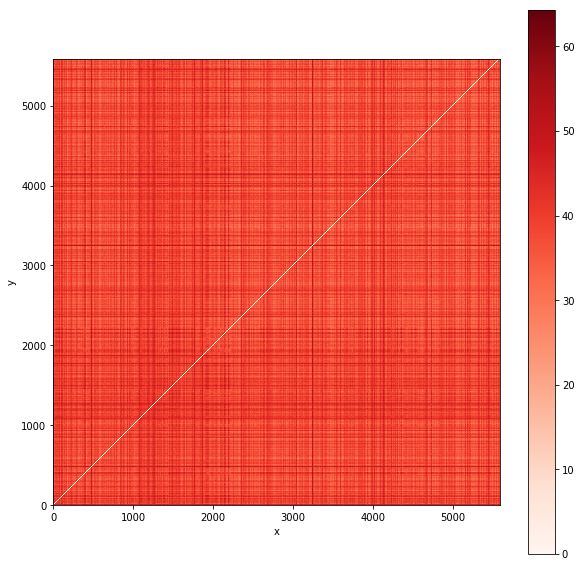

In [25]:
distance_cost_plot(dist)

#### Calculate:
- global min_value 
- global max_value
- low percentile
- high percentile

In [26]:
mask = np.ones(dist.shape, dtype=bool)
np.fill_diagonal(mask, 0)
min_value = dist[mask].min()
max_value = dist[mask].max()
low_q = np.quantile(dist[mask],0.001,)
high_q = np.quantile(dist[mask],0.999)

low = np.where((dist < low_q) & (dist >= min_value))
high = np.where(dist > high_q)

- Plot low percentile distances

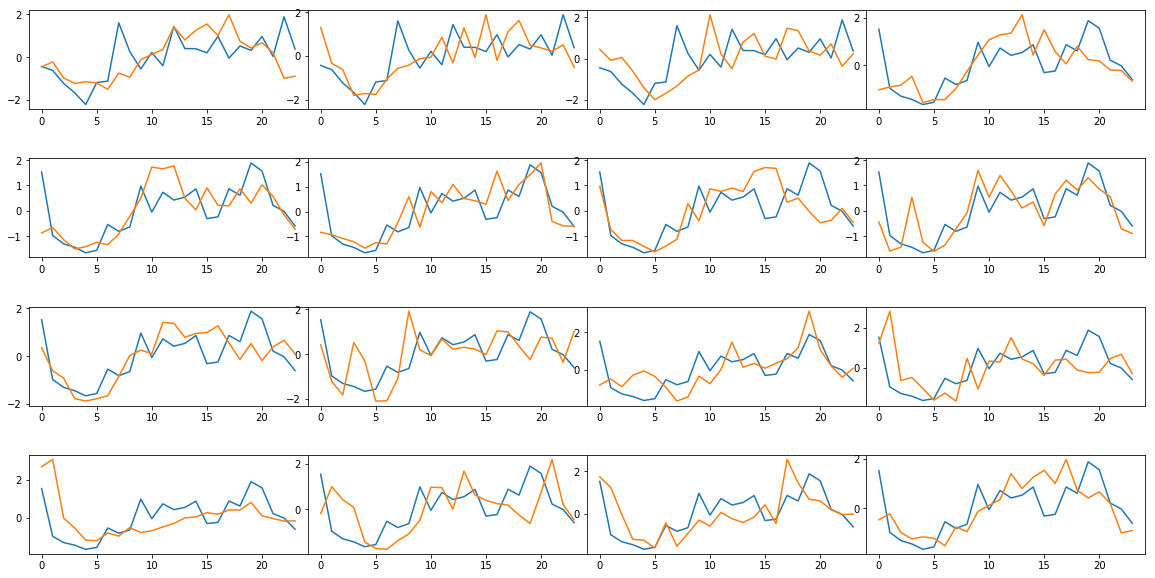

In [27]:
fig, axs = plt.subplots(4,4, figsize=(20, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(16):
    r1 = reshaped_std.iloc[low[0][i],:].values
    r2 = reshaped_std.iloc[low[1][i],:].values
    axs[i].plot(r1)
    axs[i].plot(r2)

- Plot high percentile distances

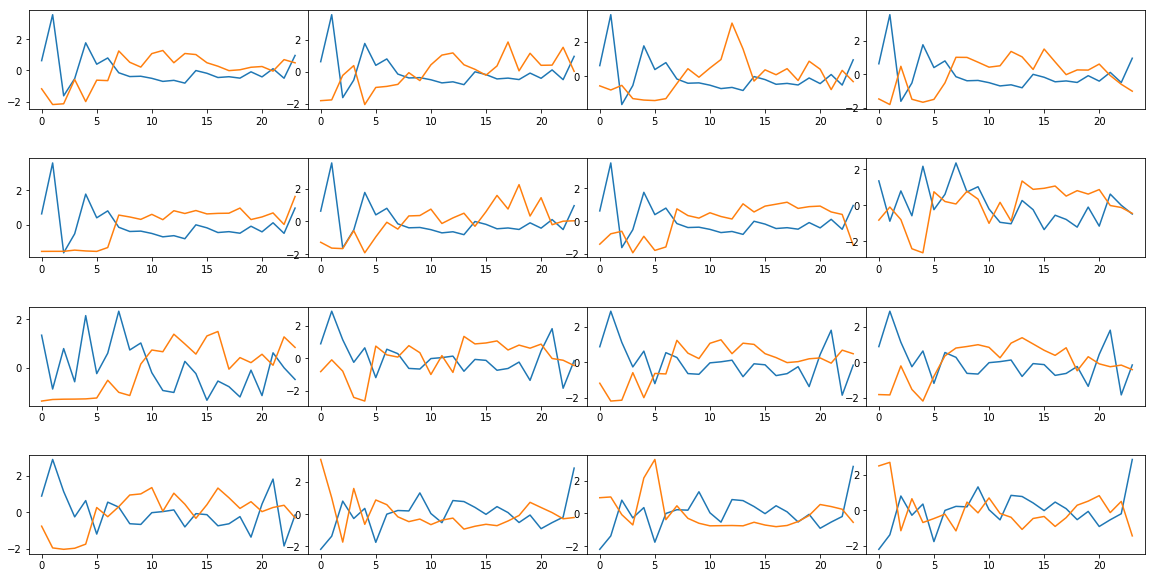

In [18]:
fig, axs = plt.subplots(4,4, figsize=(20, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(16):
    r1 = reshaped_std.iloc[high[0][i],:].values
    r2 = reshaped_std.iloc[high[1][i],:].values
    axs[i].plot(r1)
    axs[i].plot(r2)

## Sequences Grouping

- Define distance threshold

In [1067]:
# dist_threshold = 0.5

- Filter all pair of sectors with distance < k
- Collect

In [1068]:
# new_dist = dist.copy()
# res = np.argwhere((new_dist < dist_threshold) & (new_dist != 0))

# resb = res[:,1]
# counter = collections.Counter(resb)

- Define the number of clusters
- Find popular sectors

In [1069]:
# cl = 10
# pop = counter.most_common(cl)

# clusters_indexes = []

# for i in range(cl):
#     clusters_indexes.append(res[res[:,1] == pop[i][0]][:,0])

- Plot a cluster

In [1070]:
# s = 0

# plt.plot(reshaped.iloc[pop[s][0]],linewidth=5,label = 'popular')
# for i in range(len(clusters_indexes[s])):
#     plt.plot(reshaped.iloc[clusters_indexes[s][i]])
# #plt.legend()

In [1071]:
# clusters_group = []

# for i in range(cl):
#     clusters_group.append(reshaped.iloc[clusters_indexes[i]])

- Save and study a cluster in space

In [1072]:
# clusters_group_test = clusters_group[0]
# clusters_group_test = dropped.loc[dropped['Cellular sector ID'].isin(clusters_group_test.index)]

# # clusters_group_test.to_csv('clusters_group_test.csv')

## DBSCAN 

In [1073]:
# clustering = DBSCAN(eps=1, min_samples=5, metric='precomputed').fit(dist)

In [1074]:
# col = collections.Counter(clustering.labels_)
# col

In [1075]:
# clusters0 = np.where(clustering.labels_==-1)
# clusters1 = np.where(clustering.labels_==0)

In [1076]:
# cluster0_dbscan = reshaped.iloc[clusters0]
# cluster1_dbscan = reshaped.iloc[clusters1]

## Community Detection - Louvain

In [28]:
subdist = dist.copy()
# subdist = subdist[:20,:20]
# distance_cost_plot(subdist)

#### Do not run Louvain without pruning the graph

- Build the network graph
    - Add the connections between all nodes
    - Weight is defined as the distance between two nodes

In [42]:
# G = nx.from_numpy_matrix(subdist)

- Visualize the graph

In [43]:
# pos = nx.spring_layout(G, scale=50.)
# nx.draw_networkx_nodes(G, pos)
# nx.draw_networkx_edges(G,pos)
# nx.draw_networkx_labels(G,pos)
# plt.axis('off')
# plt.show()

- compute the best partition based on Louvein heuristics
    - Resolution can be a hyperparameter

In [44]:
# partition = community.best_partition(G,resolution = 0.005)

- Compute modularity

In [45]:
# community.modularity(partition,G)

#### K-Nearest Neigbors (KNN)
- Time Series Clustering via Community Detection in Networks, Ferreira et al.

- Replace the diagonal with inf values

In [29]:
subdist[subdist == 0] = 'inf'

- Sort each row of the distance matrix 
    - Return a sorted matrix with weights
    - Return a sorted matrix with indexes

In [30]:
srt_weights = np.sort(subdist, axis=1)
srt_indexes = np.argsort(subdist, axis=1)

- KNN algorithm
    - Select number of neighbours
    - Return a matrix with shape [number_of_neighbours,number_of_sectors]

In [31]:
neighbours = 5
knn = srt_indexes[:,:neighbours].T

- Build the network graph
    - Add the connection between the nodes
    - Weight is defined as the distance between two nodes

In [32]:
G = nx.Graph()
for i in range(knn.shape[1]):
    for j in range(knn.shape[0]):
        G.add_edge(i, knn[j][i], weight=srt_weights[i][j])

- Visualize the graph

In [33]:
# pos = nx.spring_layout(G, scale=50.)
# nx.draw_networkx_nodes(G, pos)
# nx.draw_networkx_edges(G,pos)
# nx.draw_networkx_labels(G,pos)
# plt.axis('off')
# plt.show()

- compute the best partition based on Louvein heuristics
    - Resolution can be a hyperparameter

In [34]:
partition = community.best_partition(G,resolution = 0.01)

In [35]:
community.modularity(partition,G)

0.12774635262580883

- Communities

In [36]:
how_many_communities = len(set(list(partition.values())))
how_many_communities

2343

- Create the communities

In [54]:
c = []

for i in range(how_many_communities):
    c.append(dict((key,value) for key, value in partition.items() if value == i))

In [55]:
clusters = []

for i in range(how_many_communities):
    clusters.append(reshaped_std.iloc[list(c[i].keys())])

- Plot a cluster

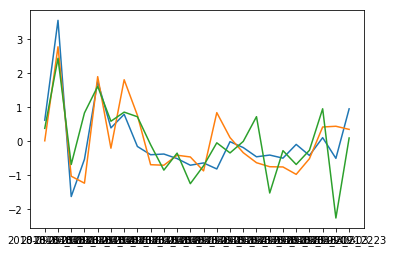

In [56]:
plt.plot(clusters[0].T)

### Optimization of hyperparameters

- Optimize Resolution

In [1127]:
mod = []
for i in range(0,10):
    partition = community.best_partition(G,resolution = 0.1*i)
    mod.append(community.modularity(partition,G))
    # print(community.modularity(partition,G))

Text(0,0.5,'modularity')

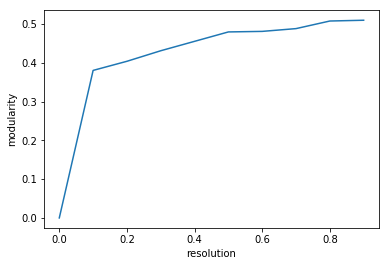

In [1128]:
plt.plot([0.1*i for i in range(0,10)], mod)
plt.xlabel('resolution')
plt.ylabel('modularity')

- Optimize K

In [624]:
modres = []
clres = []
for k in range(1,11):
    mod = []
    cl = []
    for l in range(1,11):
        neighbours = l
        knn = srt_indexes[:,:neighbours].T

        G = nx.Graph()
        for i in range(knn.shape[1]):
            for j in range(knn.shape[0]):
                G.add_edge(i, knn[j][i], weight=srt_weights[i][j])

        partition = community.best_partition(G,resolution = 0.1*k)
        mod.append(community.modularity(partition,G))
        cl.append(len(set(list(partition.values()))))
        # print(community.modularity(partition,G))
    modres.append(mod)
    clres.append(cl)

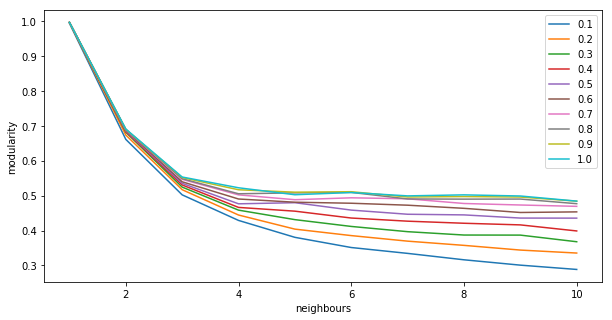

In [625]:
plt.figure(figsize=(10,5))

for j in range(10):
    plt.plot([i+1 for i in range(10)], modres[j],label = round(j*0.1+0.1,2))
    plt.xlabel('neighbours')
    plt.ylabel('modularity')
plt.legend()

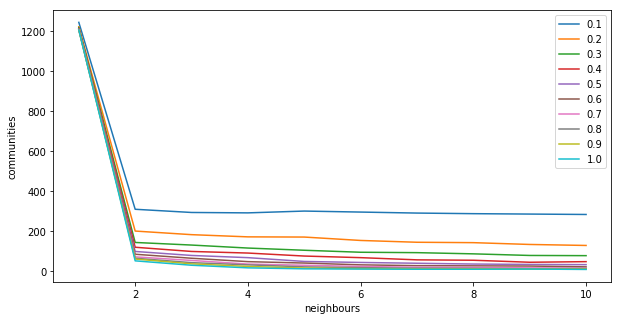

In [626]:
plt.figure(figsize=(10,5))

for j in range(10):
    plt.plot([i+1 for i in range(10)], clres[j],label = round(j*0.1+0.1,2))
    plt.xlabel('neighbours')
    plt.ylabel('communities')
plt.legend()

### Optimizing K, resolution
- Anomalies per community given different configurations of K and resolution

- Set the deviation threshold for anomaly detection 

In [37]:
th = 1

In [38]:
modres = []
clres = []
anomalies_k = []
for k in range(-2,1):
    mod = []
    cl = []
    anomalies_neighbors = []
    for l in range(1,11):
        if ((l == 2) | (l == 5) | (l == 10)):
            print(l)
            neighbours = l
            knn = srt_indexes[:,:neighbours].T

            G = nx.Graph()
            for i in range(knn.shape[1]):
                for j in range(knn.shape[0]):
                    G.add_edge(i, knn[j][i], weight=srt_weights[i][j])

            partition = community.best_partition(G,resolution = 10**k)
            mod.append(community.modularity(partition,G))
            how_many_communities = len(set(list(partition.values())))
            cl.append(how_many_communities)
            # print(community.modularity(partition,G))

            c = []

            for i in range(how_many_communities):
                c.append(dict((key,value) for key, value in partition.items() if value == i))

            clusters = []

            for i in range(how_many_communities):
                clusters.append(reshaped_std.iloc[list(c[i].keys())])

            anomalies_communities = []
            for w in range(how_many_communities):
                CST = clusters[w] # 1 community
                m = CST.mean()
                s = CST.std()

                anomalies = []

                for z in range(CST.shape[0]):
                    anomalies.append((CST.iloc[z,:] > m + th*s).sum() + (CST.iloc[z,:] < m - th*s).sum())

                anomalies_communities.append(sum(anomalies))


            anomalies_neighbors.append(anomalies_communities)
        
    modres.append(mod)
    clres.append(cl)
    anomalies_k.append(anomalies_neighbors)

2
5
10
2
5
10
2
5
10


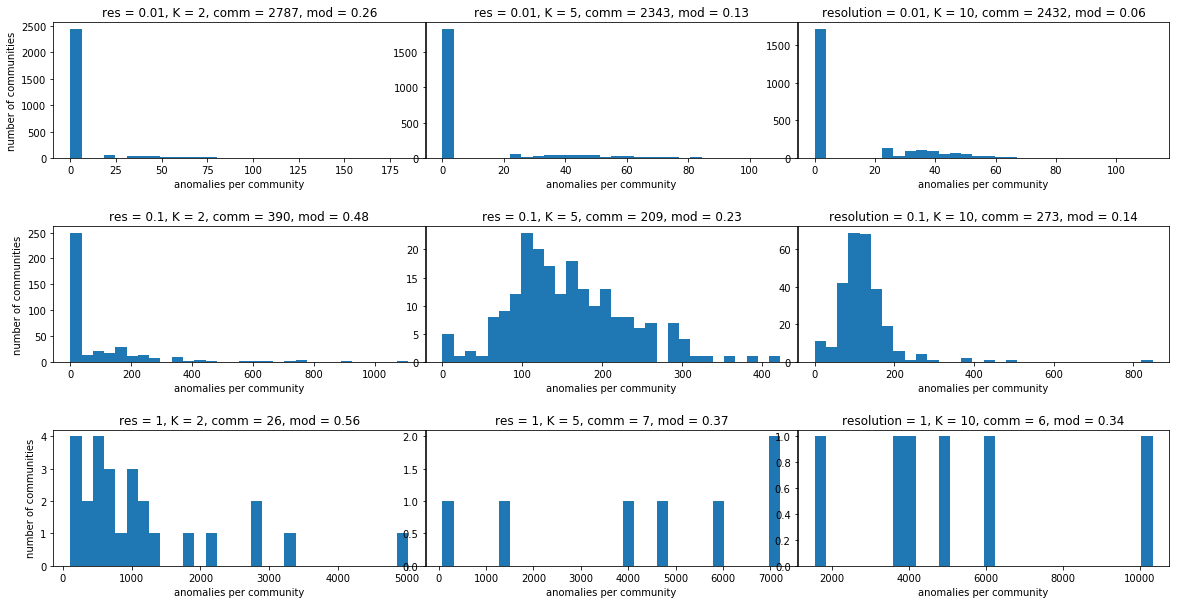

In [39]:
fig, axs = plt.subplots(3,3, figsize=(20, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

titles = ['res = 0.01, K = 2, ','res = 0.01, K = 5, ','resolution = 0.01, K = 10, ',
         'res = 0.1, K = 2, ','res = 0.1, K = 5, ','resolution = 0.1, K = 10, ',
         'res = 1, K = 2, ','res = 1, K = 5, ','resolution = 1, K = 10, '] 
n = -1
for i in range(3):
    for j in range(3):
        n = n + 1
        axs[n].hist(anomalies_k[i][j],bins=30,label = 'asd')
        axs[n].set_title(titles[n] + 'comm = ' + str(clres[i][j]) + ', mod = ' + str(round(modres[i][j],2)))
        axs[n].set_xlabel('anomalies per community')
        if ((n == 0) | (n == 3) | (n == 6)):
            axs[n].set_ylabel('number of communities')

## Anomaly detection

- Pick one cluster

In [60]:
CST = clusters[10]

- Calculate mean and standard deviation per day

In [61]:
m = CST.mean()
s = CST.std()

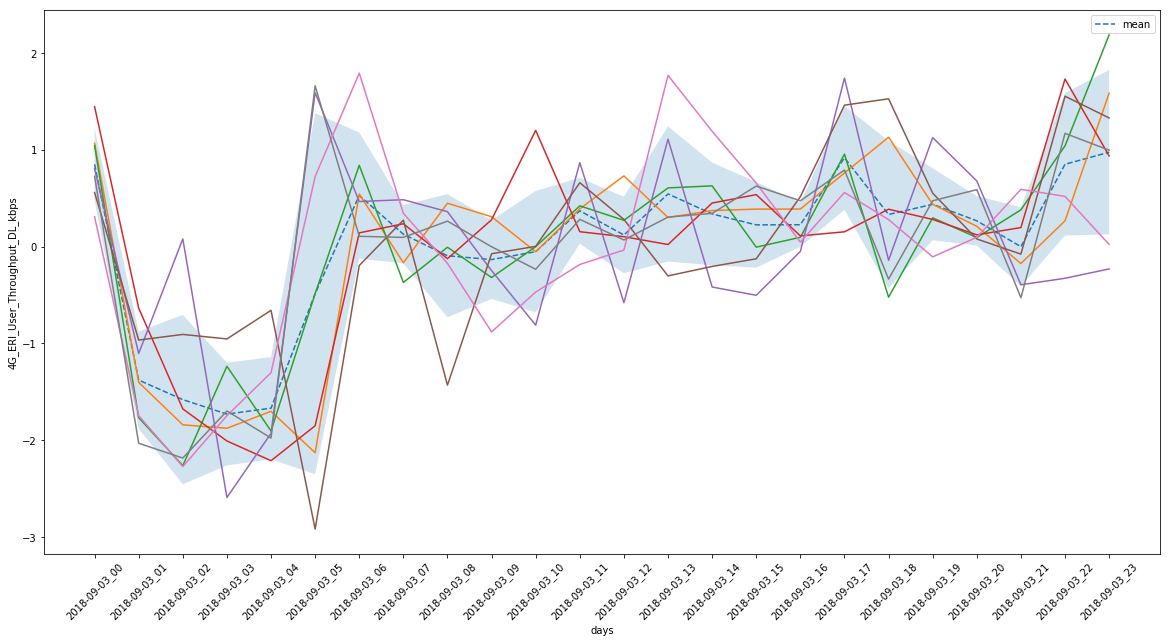

In [62]:
plt.figure(figsize=(20,10))
plt.plot(m,label = 'mean', ls='--',)
plt.xticks(rotation=45)

# plt.plot(m+s/2,label = 'std_u')
# plt.plot(m-s/2,label = 'std_l')
plt.fill_between(m.index, m + th*s, m - th*s, alpha=0.2)
plt.plot(CST.T)
plt.xlabel('days')
plt.ylabel('4G_ERI_User_Throughput_DL_kbps')
plt.legend()

In [63]:
anomalies = []

for i in range(CST.shape[0]):
    anomalies.append((CST.iloc[i,:] > m + th*s).sum() + (CST.iloc[i,:] < m - th*s).sum())

(array([1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2.]),
 array([ 4. ,  4.6,  5.2,  5.8,  6.4,  7. ,  7.6,  8.2,  8.8,  9.4, 10. ,
        10.6, 11.2, 11.8, 12.4, 13. ]),
 <a list of 15 Patch objects>)

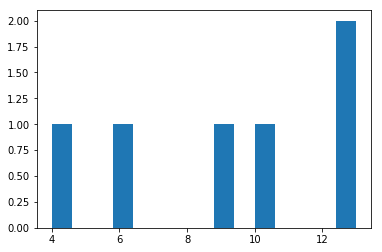

In [1133]:
plt.hist(anomalies,bins=15)

#### ?
- Adaptive Kalman Filtering for Anomaly Detection in Software Appliances

## Ranking

In [1011]:
df_anomalies = pd.DataFrame({'SectorID': [], 'Date': [], 'D': []})

for i in range(len(clusters)):
    bs = 0
    CST = clusters[i]
    for j in range(CST.shape[0]):
        m = CST.mean()
        s = CST.std()
        distn = abs(m - CST.iloc[j])/s
        if (distn.max() > bs):
            bs = np.nanmax(distn)
            day = distn.index[np.nanargmax(distn)]
            sid = CST.iloc[j].name
    df_anomalies = df_anomalies.append({'SectorID': sid, 'Date': day, 'D': bs}, ignore_index=True) 
    
    

- Sort df_anomalies by D and select the top N elements

In [1028]:
srt = df_anomalies.sort_values(by=['D'])
ind = srt[-9:]
ind = ind.iloc[::-1]

- Plotting

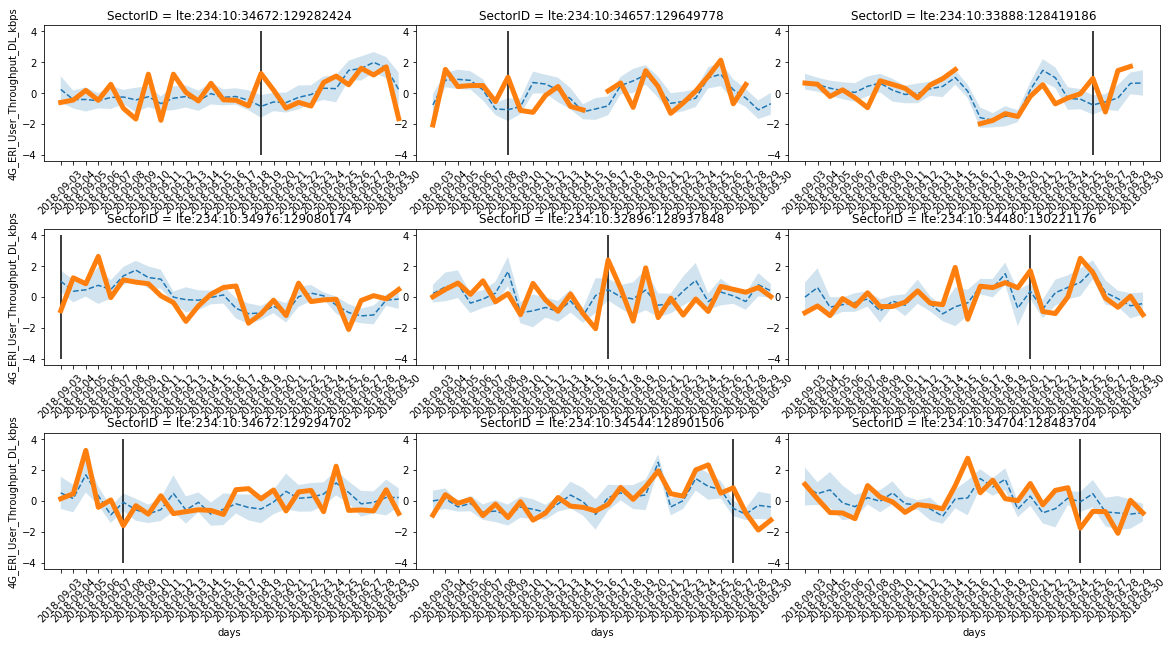

In [1032]:
fig, axs = plt.subplots(3,3, figsize=(20, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(9):
    CST = clusters[ind.index[i]]

    m = CST.mean()
    s = CST.std()

    axs[i].plot(m,label = 'mean', ls='--')
    axs[i].xaxis.set_tick_params(rotation=45)

    # plt.plot(m+s/2,label = 'std_u')
    # plt.plot(m-s/2,label = 'std_l')
    axs[i].fill_between(m.index, m + th*s, m - th*s, alpha=0.2)
    #plt.plot(CST.T)
    axs[i].plot(CST.loc[ind.iloc[i]['SectorID']],linewidth = 5)
    axs[i].set_title('SectorID = '+ind.iloc[i]['SectorID'])
    if ((i == 0) | (i == 3) | (i == 6)):
        axs[i].set_ylabel('4G_ERI_User_Throughput_DL_kbps')
    if ((i == 6) | (i == 7) | (i == 8)):
            axs[i].set_xlabel('days')

    axs[i].vlines(ind.iloc[i]['Date'],-4,4)
    #plt.xlabel('days')
    #plt.ylabel('4G_ERI_User_Throughput_DL_kbps')
    #plt.plot()
    #plt.legend()

#### Dive into specific communities

In [1174]:
# data[data['Cellular sector ID'] == ind['SectorID'].values[0]]

In [1171]:
subset = dropped.loc[data['Cellular sector ID'].isin(clusters[714].index)]
subset = subset.sort_values('date').reset_index(drop = True)
subset.to_csv('kostaskostas.csv')